In [ ]:
!pip install -q diffusers

In [ ]:
import torchvision
import torch.nn as nn
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from diffusers.utils import make_image_grid
import math
from tqdm.auto import tqdm
import torch

In [ ]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
print("Label: ", dataset[0][1])
print("Image Size: ", dataset[0][0].shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]

Label:  5
Image Size:  torch.Size([1, 28, 28])


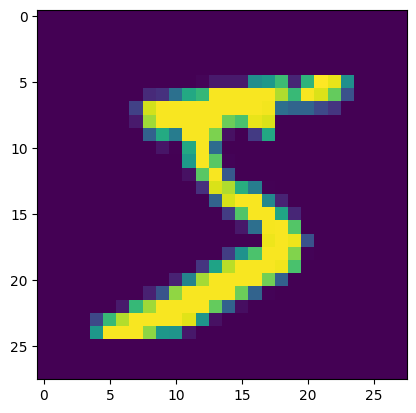

In [ ]:
example_image = np.array(dataset[0][0].squeeze(0))
plt.imshow(example_image)
plt.show()

In [ ]:
import torch
import math

class NoiseScheduler:
    def __init__(self, timesteps, beta_start, beta_end, schedule_type='linear', device='cpu'):
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        if schedule_type == 'linear':
            self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        elif schedule_type == 'cosine':
            s = 0.008
            steps = timesteps + 1
            x = torch.linspace(0, timesteps, steps, device=device)
            alphas_cumprod = torch.cos(((x / timesteps + s) / (1 + s)) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize
            self.betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
            self.betas = torch.clamp(self.betas, 1e-5, 0.999)

        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x_0, t, noise=None):
        if isinstance(t, torch.Tensor):
            t = t.detach().cpu()  # Ensure it is not detached unnecessarily
        bs = x_0.shape[0]
        sqrt_alpha_hat_t = torch.sqrt(self.alpha_hat[t].to(x_0.device)).view(bs, 1, 1, 1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alpha_hat[t].to(x_0.device)).view(bs, 1, 1, 1)

        if noise is None:
            noise = torch.randn_like(x_0, device=x_0.device)

        return sqrt_alpha_hat_t * x_0 + sqrt_one_minus_alpha_hat_t * noise


In [ ]:
timesteps = 400
ns_linear = NoiseScheduler(timesteps, 1e-4, 0.02, 'linear')
ns_cosine = NoiseScheduler(timesteps, 1e-4, 0.02, 'cosine')

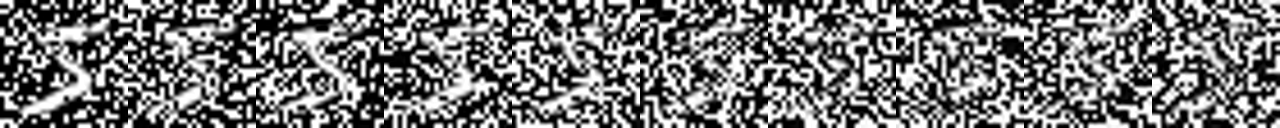

In [ ]:
linear_grid = []
cosine_grid = []
for t in range(0, 10, 1):
    linear_grid.append(ns_linear.forward_process(dataset[0][0], t))
    cosine_grid.append(ns_cosine.forward_process(dataset[0][0], t))

make_image_grid([Image.fromarray((x*255).squeeze(0).squeeze(0).numpy().astype(np.uint8)) for x in linear_grid], rows=1, cols=10, resize=128)

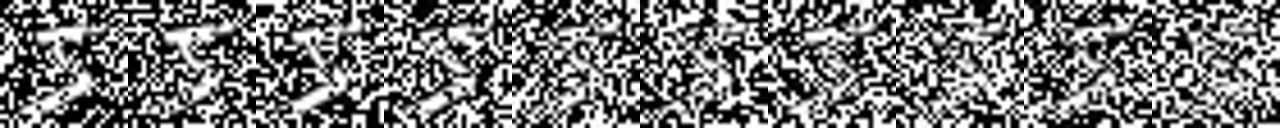

In [ ]:
make_image_grid([Image.fromarray((x*255).squeeze(0).squeeze(0).numpy().astype(np.uint8)) for x in cosine_grid], rows=1, cols=10, resize=128)

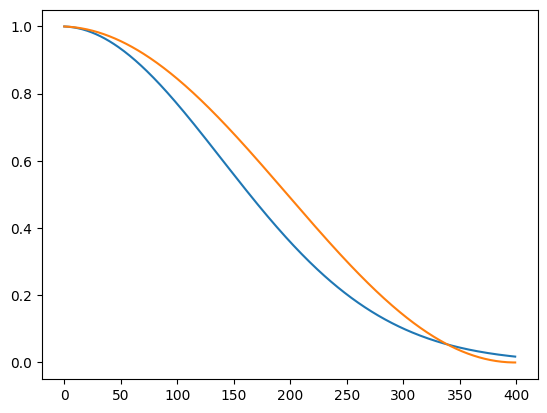

In [ ]:
plt.plot(ns_linear.alpha_hat)
plt.plot(ns_cosine.alpha_hat)

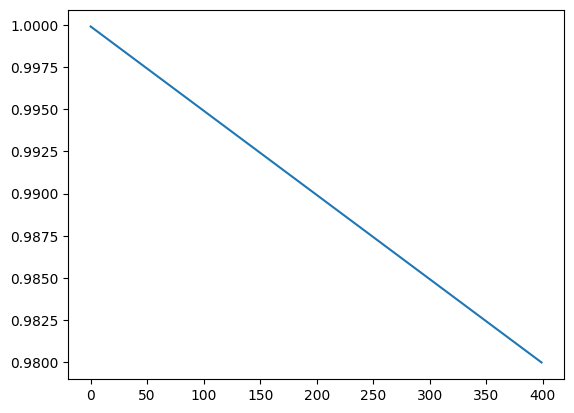

In [ ]:
plt.plot(ns_linear.alphas)
# plt.plot(ns_cosine.alphas)

In [ ]:
class TimeStepEmbedding(nn.Module):
  def __init__(self, embedding_dim):
     super().__init__()
     self.embedding_dim = embedding_dim
     self.max_period = 100000
     self.mlp = nn.Sequential(
         nn.Linear(embedding_dim, embedding_dim*4),
         nn.ReLU(),
         nn.Linear(embedding_dim*4, embedding_dim*4)
     )

  @staticmethod
  def timestep_emb(t, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=t.device) / half)
    args = t[:, None].float() * freqs[None, :]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
      embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

  def forward(self, t):
    t_freq = self.timestep_emb(t, self.embedding_dim, self.max_period)
    t_emb = self.mlp(t_freq)
    return t_emb

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, t_emb_dim, up_conv=False):
    super().__init__()
    if up_conv:
      self.conv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, padding=0, stride=2)
    else:
      self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)


    self.norm = nn.GroupNorm(1, out_channels)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
    self.act = nn.ReLU()
    self.emb_layer = nn.Linear(t_emb_dim, out_channels)

  def forward(self, x, t_emb):
    x = self.conv1(x)
    emb = self.emb_layer(t_emb)
    while len(emb.shape) < len(x.shape):
      emb = emb[..., None]
    x = x + emb
    x = self.norm(x)
    x = self.act(x)
    x = self.conv2(x)
    return x

In [ ]:
class Unet(nn.Module):
  def __init__(self, feature_dims = [1, 64, 128]):
    super().__init__()
    self.in_channels = feature_dims[0]
    self.timestep_embedding = TimeStepEmbedding(feature_dims[1])
    self.label_embedding = nn.Embedding(10, feature_dims[1]*4)


    # Scale-1
    self.conv_block1 = ConvBlock(self.in_channels, feature_dims[1], 3, 1, feature_dims[1]*4)
    self.conv_block2 = ConvBlock(feature_dims[1], feature_dims[1], 3, 1, feature_dims[1]*4)

    # Downsample
    self.downsample1 = nn.Conv2d(feature_dims[1], feature_dims[1], kernel_size=3, stride=2, padding=1)

    # Scale-2
    self.conv_block3 = ConvBlock(feature_dims[1], feature_dims[2], 3, 1, feature_dims[1]*4)
    self.conv_block4 = ConvBlock(feature_dims[2], feature_dims[2], 3, 1, feature_dims[1]*4)

    # Downsample
    self.downsample2 = nn.Conv2d(feature_dims[2], feature_dims[2], kernel_size=3, stride=2, padding=1)


    self.bottleneck = nn.Sequential(nn.Conv2d(feature_dims[2], feature_dims[2], 3, 1, 1), nn.GroupNorm(1, feature_dims[2]), nn.ReLU(), nn.Conv2d(feature_dims[2], feature_dims[2], 3, 1, 1))

    #Scale-2
    self.up_conv1 = ConvBlock(feature_dims[2]*2, feature_dims[2], 3, 1, feature_dims[1]*4, up_conv=True)
    self.up_conv2 = ConvBlock(feature_dims[2]*2, feature_dims[2], 3, 1, feature_dims[1]*4, up_conv=False)

    #Scale-1
    self.up_conv3 = ConvBlock(feature_dims[2]*2, feature_dims[1], 3, 1, feature_dims[1]*4, up_conv=True)
    self.up_conv4 = ConvBlock(feature_dims[1]*2, feature_dims[1], 3, 1, feature_dims[1]*4, up_conv=False)


    self.final_conv = nn.Conv2d(feature_dims[1]*2, feature_dims[0], 3, 1,1)


  def forward(self, x, t, y=None):
    t_emb = self.timestep_embedding(t) # Bx(4*64)
    emb = self.label_embedding(y) # Bx(4*64)
    emb = emb + t_emb
    batch_size = x.shape[0]

    s1_1 = self.conv_block1(x, emb) # Bx(64)x28x28
    s1_2 = self.conv_block2(s1_1, emb) # Bx(64)x28x28
    s2_init = self.downsample1(s1_1) # Bx(64)x14x14
    s2_1 = self.conv_block3(s2_init, emb) # Bx(128)x14x14
    s2_2 = self.conv_block4(s2_1, emb)# Bx(128)x14x14
    s3_init = self.downsample2(s2_1) #Bx(128)x7x7

    up_init = self.bottleneck(s3_init) # Bx(128)x7x7
    # print(up_init.shape, s3_init.shape)

    s3 = self.up_conv1(torch.cat([up_init, s3_init], dim=1), emb) #Bx(128)x14x14
    s3 = self.up_conv2(torch.cat([s3,s2_2], dim=1), emb) #Bx(128)x14x14
    s4 = self.up_conv3(torch.cat([s3, s2_1], dim=1), emb) #Bx(64)x28x28
    s4 = self.up_conv4(torch.cat([s4, s1_2], dim=1), emb) #Bx(64)x28x28
    s5 = self.final_conv(torch.cat([s4, s1_1], dim=1)) #Bx(1)x28x28
    return s5

In [ ]:
model = Unet()
O = model(torch.randn((1,1,28,28)), torch.tensor([5]), torch.tensor([9]))
print(O.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))



torch.Size([1, 1, 28, 28])
2327681


In [ ]:
batch_size = 128
traindl = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
n_epochs = 20
device = "cuda"

model = model.to(device)
loss_fn = nn.MSELoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
for epoch in range(n_epochs):
  for x,y in tqdm(traindl):
    x = x.to(device)
    y = y.to(device)

    noise = torch.randn_like(x)

    tt = torch.randint(0, timesteps, (batch_size,), device=x.device).long()
    noisy_x = ns_cosine.forward_process(x, tt, noise=noise)

    opt.zero_grad()
    pred = model(noisy_x, tt, y)
    loss = loss_fn(pred, noise)

    loss.backward()
    opt.step()

    losses.append(loss.item())
  avg_loss = sum(losses[-len(traindl) :]) / len(traindl)
  print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 0. Average loss for this epoch: 0.135660


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 1. Average loss for this epoch: 0.043178


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 2. Average loss for this epoch: 0.036269


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 3. Average loss for this epoch: 0.034010


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 4. Average loss for this epoch: 0.032455


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 5. Average loss for this epoch: 0.031682


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 6. Average loss for this epoch: 0.030730


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 7. Average loss for this epoch: 0.029910


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 8. Average loss for this epoch: 0.029793


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 9. Average loss for this epoch: 0.029253


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 10. Average loss for this epoch: 0.028912


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 11. Average loss for this epoch: 0.028552


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 12. Average loss for this epoch: 0.028610


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 13. Average loss for this epoch: 0.028327


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 14. Average loss for this epoch: 0.027891


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 15. Average loss for this epoch: 0.027766


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 16. Average loss for this epoch: 0.027857


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 17. Average loss for this epoch: 0.027628


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 18. Average loss for this epoch: 0.027588


  0%|          | 0/468 [00:00<?, ?it/s]

Finished epoch 19. Average loss for this epoch: 0.027363


In [ ]:
@torch.inference_mode()
def sample(model, labels, device, timesteps, ns):
    n = len(labels)
    model.eval()

    x = torch.randn((n, 1, 28, 28)).to(device)
    for i in tqdm(reversed(range(timesteps)), total=timesteps, leave=False):
        t = torch.full((n,), i, device=device, dtype=torch.long)

        predicted_noise = model(x, t, labels)

        alpha = ns.alphas[t].view(-1, 1, 1, 1).to(device)
        alpha_hat = ns.alpha_hat[t].view(-1, 1, 1, 1).to(device)
        beta = ns.betas[t].view(-1, 1, 1, 1).to(device)

        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise

    x = x.clamp(0, 1)
    x = (x * 255).type(torch.uint8)
    return x

In [ ]:
ns_cosine.alphas = ns_cosine.alphas.to(device)
ns_cosine.alpha_hat = ns_cosine.alpha_hat.to(device)
ns_cosine.betas = ns_cosine.betas.to(device)

  0%|          | 0/400 [00:00<?, ?it/s]

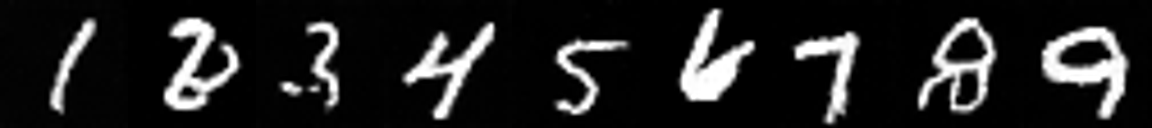

In [ ]:
I = sample(model, torch.tensor([1,2,3,4,5,6,7,8,9]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(9)], rows=1, cols=9, resize=128)

  0%|          | 0/400 [00:00<?, ?it/s]

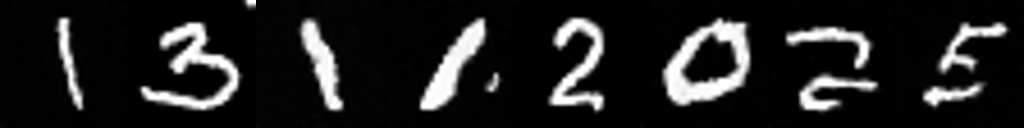

In [ ]:
I = sample(model, torch.tensor([1,3,1,1,2,0,2,5]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(8)], rows=1, cols=8, resize=128)

In [ ]:
I = sample(model, torch.tensor([1,3,1,1,2,0,2,5]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(8)], rows=1, cols=8, resize=128)

  0%|          | 0/400 [00:00<?, ?it/s]

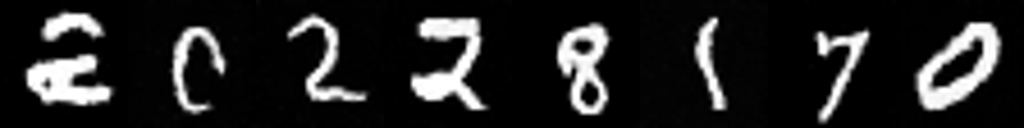

In [ ]:
I = sample(model, torch.tensor([2,0,2,2,8,1,7,0]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(8)], rows=1, cols=8, resize=128)

  0%|          | 0/400 [00:00<?, ?it/s]

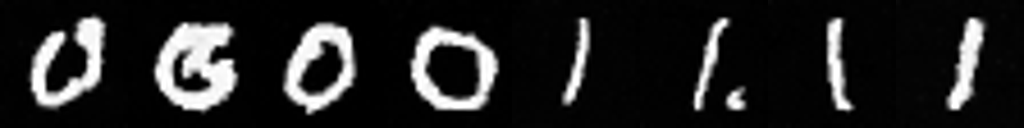

In [ ]:
I = sample(model, torch.tensor([0,0,0,0,1,1,1,1]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(8)], rows=1, cols=8, resize=128)

  0%|          | 0/400 [00:00<?, ?it/s]

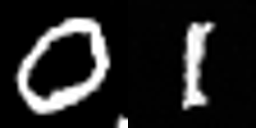

In [ ]:
I = sample(model, torch.tensor([0,1]).to(device), device, timesteps, ns_cosine)
make_image_grid([Image.fromarray(I.squeeze(0).detach().cpu().numpy()[k].squeeze()) for k in range(2)], rows=1, cols=2, resize=128)